# Creating KG vectors from a cluster of nodes

## Importing essential libraries

In [1]:
import pickle, json, requests, csv, copy, os, re
import numpy as np
import pprint as pp
import urllib.request, urllib.parse
from sklearn.metrics.pairwise import cosine_similarity
from json import JSONDecodeError
from text_to_uri import *

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

## Global variables initialisation

In [2]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

pos_dict = {'JJ': 'a', 'JJR': 'a', 'JJS': 'a',
           'NN': 'n', 'NNP': 'n', 'NNPS': 'n', 'NNS': 'n',
           'RB': 'r', 'RBR': 'r', 'RBS': 'r',
           'VB': 'v', 'VBD': 'v', 'VBG': 'v', 'VBN': 'v', 'VBP': 'v', 'VBZ': 'v'}

In [3]:
NODES_DATA = dict()
lemmatise_dict = dict()

## Functions

### Category (Class) related functions

In [4]:
class Category:
    
    def __init__(self, label, description, hierarchy): # Create an empty path
        self.label = label.strip().lower()
        self.description = description.strip().lower()
        self.hierarchy = hierarchy.strip().lower().split(';')
        self.nodes = {'the_class':[],
                      'super_class':[],
                      'description':[],
                     }
        self.find_nodes()
    
    def __repr__(self):
        return self.label + ' => \n' + '\n'.join([key + ': ' + str(val) for key, val in self.nodes.items()]) + '\n'
    
    def find_nodes(self):
        # The class
        self.nodes['the_class'] = get_all_nodes_from_label(self.label)
                
        # Super class
        for a_super_class in self.hierarchy:
            self.nodes['super_class'].extend(get_all_nodes_from_label(a_super_class))
        self.nodes['super_class'] = list(set(self.nodes['super_class']))
        
        # Description
        text = nltk.pos_tag(word_tokenize(self.description))
        for token in text:
            if token[1].startswith('NN') and token[0] not in stop_words: # Noun and not stop words
#                 lemmatised_token = lemmatizer.lemmatize(token[0], pos="n")
#                 self.nodes['description'].extend(get_all_nodes_from_label(lemmatised_token))
                self.nodes['description'].extend(get_all_nodes_from_label(token[0]))
        self.nodes['description'] = list(set(self.nodes['description']))
       
    def get_all_nodes(self):
        ans = []
        for key, val in self.nodes.items():
            ans.extend(val)
        return set(ans)

In [5]:
def get_class_info(filename):
    with open(filename, encoding = 'utf-8') as csvfile:
        reader = csv.DictReader(csvfile, delimiter=',')
        ans = [row for row in reader]
        print("No. of classes =", len(ans))
        print("Header =", ans[0].keys())
        return ans

In [6]:
def get_all_nodes_from_label(label):
    ans = []
    if standardized_uri('en', label) in NODES_DATA:
        ans.append(standardized_uri('en', label))
    for token in label.split():
        if token not in stop_words:
            token = lemmatise_ConceptNet_label(token)
            if standardized_uri('en', token) in NODES_DATA and standardized_uri('en', token) not in ans:
                ans.append(standardized_uri('en', token))
    return ans

### ConceptNet (nodes) related functions

In [7]:
class ConceptNet_node:
    
    def __init__(self, uri): # Create a node
        self.uri = remove_word_sense(uri)
        self.label = uri[uri.rfind('/')+1:]
        self.neighbors = {0: set([self.uri]),
                          1: set()}
        
    def find_neighbors(self, hop):
        if hop not in self.neighbors:
            one_hop_less = self.find_neighbors(hop-1)
            ans = set()
            for n in one_hop_less:
                ans = ans.union(NODES_DATA[n].find_neighbors(1))
            ans = ans.difference(self.find_neighbors_within(hop-1))
            self.neighbors[hop] = ans
            print('Finish finding neighbors of ', self.uri, 'hop =', hop)
        return self.neighbors[hop]
    
    def find_neighbors_within(self, hop):
        assert hop >= 0, 'Hop number must be non-negative'
        if hop == 0:
            return self.neighbors[0]
        else:
            return self.find_neighbors(hop).union(self.find_neighbors_within(hop-1))

In [8]:
def get_neighbors_of_cluster(node_set, hop):
    ans = set()
    for n in node_set:
        assert n in NODES_DATA, "Invalid node " + n
        ans = ans.union(NODES_DATA[n].find_neighbors_within(hop))
    return ans

In [9]:
def remove_word_sense(sub):
    if sub.count('/') > 3:
        if sub.count('/') > 4:
            print(sub)
            assert False, "URI error (with more than 4 slashes)"
        sub = sub[:sub.rfind('/')]
    return sub

In [10]:
def get_label_from_uri(uri):
    uri = remove_word_sense(uri)
    return uri[uri.rfind('/')+1:]

In [11]:
def lemmatise_ConceptNet_label(label):
    if '_' in label:
        return label
    else:
        tag = nltk.pos_tag([label])[0][1]
        if tag not in pos_dict:
            return label
        else:
            return lemmatizer.lemmatize(label, pos_dict[tag])

In [12]:
def lemmatise_ConceptNet_uri(uri):
    label = get_label_from_uri(uri)
    lemmatised_label = lemmatise_ConceptNet_label(label)
    return standardized_uri('en', lemmatised_label)

In [13]:
def create_lemmatised_dict(ns): # ns is a set of nodes from read_all_nodes()
    nodes = dict()
    for n in ns:
        nodes[n] = lemmatise_ConceptNet_uri(n)
    return nodes

### Loading ConceptNet functions

In [14]:
def read_all_nodes(filename): # get all distinct uri in conceptnet (without part of speech)
    nodes = set()
    with open(filename, 'r', encoding = "utf8") as csvfile:
        reader = csv.reader(csvfile, delimiter='\t')
        for line in reader:
            sub = remove_word_sense(line[2])
            obj = remove_word_sense(line[3])
            nodes.add(sub)
            nodes.add(obj)
    return nodes

In [15]:
def load_one_hop_data(filename, NODES_DATA, rel_list):
    count_edges = 0
    with open(filename, 'r', encoding = "utf8") as csvfile:
        reader = csv.reader(csvfile, delimiter='\t')
        for line in reader:
            rel = line[1].strip()
            if rel_list is None or rel in rel_list:
                details = json.loads(line[4])
                w = details['weight']
                if w < 1.0:
                    continue
                    
                sub = lemmatise_dict[remove_word_sense(line[2])]
                obj = lemmatise_dict[remove_word_sense(line[3])]
                if sub != obj:
                    NODES_DATA[sub].neighbors[1].add(obj)
                    NODES_DATA[obj].neighbors[1].add(sub)
                    count_edges += 1
    print("Total no. of registered edges =", count_edges)

In [16]:
def load_ConceptNet():
    global lemmatise_dict, NODES_DATA
    
    filename = '../wordEmbeddings/conceptnet-assertions-en-5.6.0.csv'
    
    # Find all lemmatised nodes
    ALL_NODES = read_all_nodes(filename)
    print('Before lemmatising, no. of all nodes = ', len(ALL_NODES))
    lemmatise_dict = create_lemmatised_dict(ALL_NODES)
    ALL_NODES = set(lemmatise_dict.values())
    print('After lemmatising, no. of all nodes = ', len(ALL_NODES))
    
    # Create all lemmatised nodes objects in the process
    for n in ALL_NODES:
        NODES_DATA[n] = ConceptNet_node(n)
    del ALL_NODES
    print('Finish creating lemmatised nodes')
    
    # Load one hop data from ConceptNet
#     rel_list = ['/r/IsA', '/r/PartOf', '/r/AtLocation', '/r/RelatedTo', '/r/FormOf', '/r/HasA', '/r/UsedFor', '/r/CapableOf', '/r/AtLocation', '/r/Causes']
    rel_list = ['/r/IsA', '/r/PartOf', '/r/AtLocation', '/r/RelatedTo']
    load_one_hop_data(filename, NODES_DATA, rel_list)    
    print('Finish loading one hop data')

### Creating KG vector function

In [17]:
def get_vector_of(n, all_c_nodes, hop): # n = uri, c = Category_node
    v = np.zeros(3 * hop + 1)
    v[0] = 1.0 if n in all_c_nodes else 0.0
    for i in range(hop):
        have_hops = [n in NODES_DATA[c].find_neighbors(i+1) for c in all_c_nodes]
        if len(have_hops) > 0:
            v[3 * i + 1] = float(any(have_hops))
            v[3 * i + 2] = float(sum(have_hops))
            v[3 * i + 3] = float(np.mean(have_hops))
        else:
            v[3 * i + 1] = 0.0
            v[3 * i + 2] = 0.0
            v[3 * i + 3] = 0.0
    return v

## Main Program

- Load conceptnet

In [18]:
load_ConceptNet()

Before lemmatising, no. of all nodes =  1100497
After lemmatising, no. of all nodes =  1045719
Finish creating lemmatised nodes
Total no. of registered edges = 1635198
Finish loading one hop data


- Load class data and form a cluster of nodes for each class

In [81]:
filename = "../data/review/classLabelsChen14Elec.csv"
class_nodes = set()
class_info = get_class_info(filename)
classes = [Category(c['ClassLabel'], c['ClassDescription'], c['Hierarchy']) for c in class_info]
for c in classes:
    class_nodes = class_nodes.union(c.get_all_nodes())
print(len(class_nodes), class_nodes)

No. of classes = 50
Header = odict_keys(['ClassCode', 'ClassLabel', 'ConceptNet', 'Count', 'ClassDescription', 'Hierarchy'])
203 {'/c/en/kindle', '/c/en/alarm_clock', '/c/en/video_recorder', '/c/en/alarm', '/c/en/vacuum', '/c/en/car', '/c/en/order', '/c/en/rice', '/c/en/blade', '/c/en/medium', '/c/en/reproduction', '/c/en/appliance', '/c/en/piece', '/c/en/xbox', '/c/en/flash', '/c/en/clock', '/c/en/radar', '/c/en/past', '/c/en/amazon', '/c/en/wire', '/c/en/internet', '/c/en/someone', '/c/en/device', '/c/en/musical_instruments', '/c/en/cd_player', '/c/en/bass', '/c/en/people', '/c/en/website', '/c/en/speaker', '/c/en/thing', '/c/en/email', '/c/en/microsoft', '/c/en/graphics_card', '/c/en/photograph', '/c/en/loudspeaker', '/c/en/laptop', '/c/en/e_readers', '/c/en/satellite', '/c/en/radar_detector', '/c/en/lamp', '/c/en/sky', '/c/en/tablet', '/c/en/equipment', '/c/en/set', '/c/en/time', '/c/en/picture', '/c/en/modem', '/c/en/dvd_player', '/c/en/enforcement', '/c/en/something', '/c/en/mp3_

In [82]:
for c in classes:
    print(c)

monitor => 
the_class: ['/c/en/monitor']
super_class: ['/c/en/electronics', '/c/en/computer']
description: ['/c/en/screen', '/c/en/computer', '/c/en/part']

watch => 
the_class: ['/c/en/watch']
super_class: ['/c/en/electronics']
description: ['/c/en/wrist', '/c/en/clock']

blu ray player => 
the_class: ['/c/en/ray', '/c/en/player']
super_class: ['/c/en/electronics', '/c/en/entertainment', '/c/en/home']
description: ['/c/en/ray', '/c/en/piece', '/c/en/equipment']

cd player => 
the_class: ['/c/en/cd_player', '/c/en/cd', '/c/en/player']
super_class: ['/c/en/electronics', '/c/en/entertainment', '/c/en/home']
description: ['/c/en/music', '/c/en/cd', '/c/en/piece', '/c/en/equipment']

network adapter => 
the_class: ['/c/en/network_adapter', '/c/en/network', '/c/en/adapter']
super_class: ['/c/en/electronics', '/c/en/computer', '/c/en/network']
description: ['/c/en/hardware', '/c/en/component', '/c/en/computer', '/c/en/network']

battery => 
the_class: ['/c/en/battery']
super_class: ['/c/en/e

- Find neighbors of nodes in each cluster 

In [83]:
for c in class_nodes:
    NODES_DATA[c].find_neighbors(3)

Finish finding neighbors of  /c/en/kindle hop = 2
Finish finding neighbors of  /c/en/kindle hop = 3
Finish finding neighbors of  /c/en/alarm_clock hop = 2
Finish finding neighbors of  /c/en/alarm_clock hop = 3
Finish finding neighbors of  /c/en/video_recorder hop = 2
Finish finding neighbors of  /c/en/video_recorder hop = 3
Finish finding neighbors of  /c/en/alarm hop = 2
Finish finding neighbors of  /c/en/alarm hop = 3
Finish finding neighbors of  /c/en/vacuum hop = 2
Finish finding neighbors of  /c/en/vacuum hop = 3
Finish finding neighbors of  /c/en/order hop = 2
Finish finding neighbors of  /c/en/order hop = 3
Finish finding neighbors of  /c/en/rice hop = 2
Finish finding neighbors of  /c/en/rice hop = 3
Finish finding neighbors of  /c/en/blade hop = 2
Finish finding neighbors of  /c/en/blade hop = 3
Finish finding neighbors of  /c/en/medium hop = 2
Finish finding neighbors of  /c/en/medium hop = 3
Finish finding neighbors of  /c/en/reproduction hop = 2
Finish finding neighbors of 

Finish finding neighbors of  /c/en/iron hop = 2
Finish finding neighbors of  /c/en/iron hop = 3
Finish finding neighbors of  /c/en/hard_drive hop = 2
Finish finding neighbors of  /c/en/hard_drive hop = 3
Finish finding neighbors of  /c/en/detector hop = 2
Finish finding neighbors of  /c/en/detector hop = 3
Finish finding neighbors of  /c/en/remote_control hop = 2
Finish finding neighbors of  /c/en/remote_control hop = 3
Finish finding neighbors of  /c/en/cassette hop = 2
Finish finding neighbors of  /c/en/cassette hop = 3
Finish finding neighbors of  /c/en/webcam hop = 2
Finish finding neighbors of  /c/en/webcam hop = 3
Finish finding neighbors of  /c/en/object hop = 2
Finish finding neighbors of  /c/en/object hop = 3
Finish finding neighbors of  /c/en/subwoofer hop = 2
Finish finding neighbors of  /c/en/subwoofer hop = 3
Finish finding neighbors of  /c/en/speaking hop = 2
Finish finding neighbors of  /c/en/speaking hop = 3
Finish finding neighbors of  /c/en/projector hop = 2
Finish fi

Finish finding neighbors of  /c/en/recorder hop = 2
Finish finding neighbors of  /c/en/recorder hop = 3
Finish finding neighbors of  /c/en/camera hop = 2
Finish finding neighbors of  /c/en/camera hop = 3


In [84]:
pickle.dump(NODES_DATA, open("../wordEmbeddings/NODES_DATA_amazon_3hops.pickle", "wb"))

- Calculate KG vectors for each class

In [86]:
for c in classes:
    all_c_nodes = c.get_all_nodes()
    all_neighbors = get_neighbors_of_cluster(all_c_nodes, hop = 3)
    print(c, len(all_neighbors))
    
    vectors = dict()
    for n in all_neighbors:
        # Consider all nodes as a whole group
        vectors[n] = get_vector_of(n, all_c_nodes, hop = 3) 
        
        # Consider each partition of nodes separately
#         vectors[n] = np.concatenate((get_vector_of(n, c.nodes['the_class'], hop = 3), get_vector_of(n, c.nodes['super_class'], hop = 3), get_vector_of(n, c.nodes['description'], hop = 3)), axis = 0) 

        # print(n, vectors[n])
        # break
    pickle.dump(vectors, open("../wordEmbeddings/amazon/VECTORS_CLUSTER_3_"+c.label+".pickle", "wb"))
#     pickle.dump(vectors, open("../wordEmbeddings/amazon_class_partition/VECTORS_CLUSTER_3_"+c.label+".pickle", "wb"))
    print('Finish calculating vectors for', c.label)

monitor => 
the_class: ['/c/en/monitor']
super_class: ['/c/en/electronics', '/c/en/computer']
description: ['/c/en/screen', '/c/en/computer', '/c/en/part']
 381229
Finish calculating vectors for monitor
watch => 
the_class: ['/c/en/watch']
super_class: ['/c/en/electronics']
description: ['/c/en/wrist', '/c/en/clock']
 296322
Finish calculating vectors for watch
blu ray player => 
the_class: ['/c/en/ray', '/c/en/player']
super_class: ['/c/en/electronics', '/c/en/entertainment', '/c/en/home']
description: ['/c/en/ray', '/c/en/piece', '/c/en/equipment']
 375289
Finish calculating vectors for blu ray player
cd player => 
the_class: ['/c/en/cd_player', '/c/en/cd', '/c/en/player']
super_class: ['/c/en/electronics', '/c/en/entertainment', '/c/en/home']
description: ['/c/en/music', '/c/en/cd', '/c/en/piece', '/c/en/equipment']
 383170
Finish calculating vectors for cd player
network adapter => 
the_class: ['/c/en/network_adapter', '/c/en/network', '/c/en/adapter']
super_class: ['/c/en/electron

Finish calculating vectors for microphone
tv => 
the_class: ['/c/en/tv']
super_class: ['/c/en/electronics', '/c/en/entertainment', '/c/en/home']
description: ['/c/en/screen', '/c/en/programme', '/c/en/piece', '/c/en/equipment']
 368445
Finish calculating vectors for tv
projector => 
the_class: ['/c/en/projector']
super_class: ['/c/en/electronics', '/c/en/entertainment', '/c/en/home']
description: ['/c/en/equipment', '/c/en/slide', '/c/en/screen', '/c/en/piece', '/c/en/film']
 379554
Finish calculating vectors for projector
mouse => 
the_class: ['/c/en/mouse']
super_class: ['/c/en/electronics', '/c/en/computer', '/c/en/accessory']
description: ['/c/en/screen', '/c/en/thing', '/c/en/computer', '/c/en/order', '/c/en/object']
 411949
Finish calculating vectors for mouse
voice recorder => 
the_class: ['/c/en/voice', '/c/en/recorder']
super_class: ['/c/en/electronics', '/c/en/portable']
description: ['/c/en/piece', '/c/en/equipment', '/c/en/voice']
 341953
Finish calculating vectors for voic

In [95]:
print(vectors['/c/en/large'])

[0.         0.         0.         0.         1.         3.
 0.42857143 1.         4.         0.57142857]


## Visualisation of KG Vectors

In [19]:
filename = "../data/dbpedia/classLabelsDBpedia.csv"
class_nodes = set()
class_info = get_class_info(filename)
classes = [Category(c['ClassLabel'], c['ClassDescription'], c['Hierarchy']) for c in class_info]
for c in classes:
    class_nodes = class_nodes.union(c.get_all_nodes())
print(len(class_nodes), class_nodes)

No. of classes = 14
Header = odict_keys(['ClassCode', 'ClassLabel', 'ClassDescription', 'DBpediaManual', 'ConceptNet', 'Count', 'Hierarchy'])
83 {'/c/en/building', '/c/en/government', '/c/en/transport', '/c/en/sculpture', '/c/en/file', '/c/en/kind', '/c/en/thing', '/c/en/people', '/c/en/soil', '/c/en/text', '/c/en/cinema', '/c/en/series', '/c/en/cargo', '/c/en/animal', '/c/en/mean', '/c/en/environment', '/c/en/organization', '/c/en/educational_institution', '/c/en/mp3', '/c/en/part', '/c/en/structure', '/c/en/person', '/c/en/age', '/c/en/written_work', '/c/en/sport', '/c/en/collection', '/c/en/transportation', '/c/en/painting', '/c/en/song', '/c/en/book', '/c/en/cd', '/c/en/athletics', '/c/en/position', '/c/en/music', '/c/en/plant', '/c/en/picture', '/c/en/universe', '/c/en/water', '/c/en/root', '/c/en/natural', '/c/en/leaf', '/c/en/stone', '/c/en/film', '/c/en/facility', '/c/en/write', '/c/en/sound', '/c/en/place', '/c/en/wood', '/c/en/sens', '/c/en/example', '/c/en/town', '/c/en/inst

In [63]:
def get_kg_vectors_of_sentence(sentence, vectors, prefix = '/c/en/'):
    # POS tagging and lemmatisation
    text = nltk.pos_tag(word_tokenize(sentence.lower()))
    tokens = []
    for word in text:
        tag = word[1]
        if tag not in pos_dict:
            tokens.append(word[0])
        else:
            tokens.append(lemmatizer.lemmatize(word[0], pos_dict[tag]))
    
    # Finding vectors for each lemmatised token
    length_of_vector = len(vectors[list(vectors.keys())[0]])
    ans = []
    for tok in tokens:
        print(tok)
        if prefix + tok in vectors:
            ans.append(vectors[prefix + tok][:4])
            print(vectors[prefix + tok][:4])
        else:
            ans.append(np.zeros(length_of_vector)[:4])
            print("Nooooooooooooo")
    
    return ans

In [23]:
c_label = "natural place"
vectors = pickle.load(open("../wordEmbeddings/dbpedia_class_partition/VECTORS_CLUSTER_3_"+c_label+".pickle", "rb"))

In [58]:
sentence = "East Branch Oyster River, The East Branch Oyster River is a tributary of the Oyster River in Knox County Maine. From its source (44°09′03″N 69°08′29″W) in Rockland the stream runs 4.8 miles (7.7 km) southwest to its confluence with the main stem of the Oyster River on the border between Warren and Thomaston."
vecs = np.array(get_kg_vectors_of_sentence(sentence, vectors, prefix = '/c/en/'))
print(vecs.shape, vecs)

east
[0.   0.   0.   0.   1.   1.   1.   0.   0.   0.   0.   0.   0.   0.
 1.   1.   1.   0.   0.   0.   0.   0.   0.   0.   1.   2.   0.25 1.
 6.   0.75]
branch
[0.    0.    0.    0.    1.    1.    1.    0.    0.    0.    0.    0.
 0.    0.    1.    1.    1.    0.    0.    0.    0.    1.    1.    0.125
 1.    6.    0.75  1.    1.    0.125]
oyster
[0.    0.    0.    0.    1.    1.    1.    0.    0.    0.    0.    0.
 0.    0.    1.    1.    1.    0.    0.    0.    0.    0.    0.    0.
 1.    5.    0.625 1.    3.    0.375]
river
[0.    0.    0.    0.    1.    1.    1.    0.    0.    0.    0.    0.
 0.    0.    1.    1.    1.    0.    0.    0.    0.    1.    1.    0.125
 1.    6.    0.75  1.    1.    0.125]
,
Nooooooooooooo
the
[0.    0.    0.    0.    1.    1.    1.    0.    0.    0.    0.    0.
 0.    0.    1.    1.    1.    0.    0.    0.    0.    0.    0.    0.
 1.    7.    0.875 1.    1.    0.125]
east
[0.   0.   0.   0.   1.   1.   1.   0.   0.   0.   0.   0.   0.   0.
 1.   1.   1

In [28]:
from sklearn.manifold import TSNE
vecs_embedded = TSNE(n_components=2).fit_transform(vecs)
print(vecs_embedded.shape)

(60, 2)


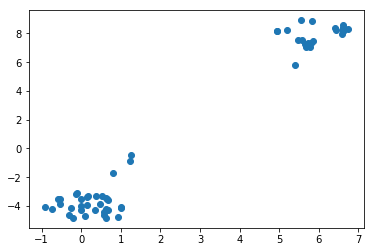

In [29]:
import matplotlib.pyplot as plt
plt.scatter(vecs_embedded[:, 0], vecs_embedded[:, 1])
plt.show()

In [67]:
sentence = "Diario Rio Negro daily newspaper General Roca provinces Río Negro Neuquén south La Pampa north Chubut south Buenos Aires Province City Buenos Aires."
class_labels = ["written work", "album", "plant", "village", "office holder", "company"]
# sentence = "East Branch Oyster River, The East Branch Oyster River is a tributary of the Oyster River in Knox County Maine. From its source (44°09′03″N 69°08′29″W) in Rockland the stream runs 4.8 miles (7.7 km) southwest to its confluence with the main stem of the Oyster River on the border between Warren and Thomaston."
# sentence = "East Branch Oyster River tributary Oyster River Knox County Maine. From source (44°09′03″N Rockland stream miles southwest confluence main stem Oyster River border Warren Thomaston."
# class_labels = ["natural place", "building", "plant", "mean of transportation", "athlete", "album"]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
ans = np.array([]).reshape(0,4)
for c_label in class_labels:
#     vectors = pickle.load(open("../wordEmbeddings/dbpedia_class_partition/VECTORS_CLUSTER_3_"+c_label+".pickle", "rb"))
    vectors = pickle.load(open("../wordEmbeddings/dbpedia/VECTORS_CLUSTER_3_"+c_label+".pickle", "rb"))
    vecs = np.array(get_kg_vectors_of_sentence(sentence, vectors, prefix = '/c/en/'))
    ans = np.concatenate((ans, vecs), axis = 0)
vecs_embedded = TSNE(n_components=2).fit_transform(ans)
print(vecs_embedded.shape)

diario
Nooooooooooooo
rio
[0. 0. 0. 0.]
negro
[0. 0. 0. 0.]
daily
[0.         1.         1.         0.14285714]
newspaper
[1.         1.         2.         0.28571429]
general
[0. 0. 0. 0.]
roca
Nooooooooooooo
province
[0. 0. 0. 0.]
río
Nooooooooooooo
negro
[0. 0. 0. 0.]
neuquén
Nooooooooooooo
south
[0. 0. 0. 0.]
la
[0. 0. 0. 0.]
pampa
[0. 0. 0. 0.]
north
[0. 0. 0. 0.]
chubut
Nooooooooooooo
south
[0. 0. 0. 0.]
buenos
Nooooooooooooo
aire
[0. 0. 0. 0.]
province
[0. 0. 0. 0.]
city
[0. 0. 0. 0.]
buenos
Nooooooooooooo
aire
[0. 0. 0. 0.]
.
Nooooooooooooo
diario
Nooooooooooooo
rio
[0. 0. 0. 0.]
negro
[0. 0. 0. 0.]
daily
[0. 0. 0. 0.]
newspaper
[0. 0. 0. 0.]
general
[0. 0. 0. 0.]
roca
Nooooooooooooo
province
[0. 0. 0. 0.]
río
Nooooooooooooo
negro
[0. 0. 0. 0.]
neuquén
Nooooooooooooo
south
[0. 0. 0. 0.]
la
[0. 0. 0. 0.]
pampa
[0. 0. 0. 0.]
north
[0. 0. 0. 0.]
chubut
Nooooooooooooo
south
[0. 0. 0. 0.]
buenos
Nooooooooooooo
aire
[0. 0. 0. 0.]
province
[0. 0. 0. 0.]
city
[0. 0. 0. 0.]
buenos
Noooo

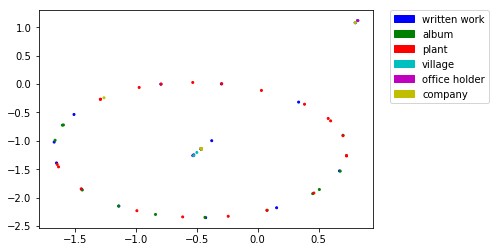

In [68]:
import matplotlib.patches as mpatches
col = [colors[i//vecs.shape[0]] for i in range(vecs_embedded.shape[0])]
plt.scatter(vecs_embedded[:, 0], vecs_embedded[:, 1], s=4, c=col)

plt.legend(handles=[mpatches.Patch(color=colors[i], label=class_labels[i]) for i in range(len(class_labels))],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


plt.show()

In [77]:
sentences = ["Xylosma /zaɪˈlɒzmə/ genus plants willow family Salicaceae. species spiny evergreen shrubs trees brushhollies more generic name Greek words (xylon) meaning wood ὀσμή (osmé) fragrant wood species.",
            "Kevin Francis James (born December Edinburgh Scotland) professional association football player career Falkirk James spells Hearts Morton Airdrieonians St. Johnstone club captain release.",
            "Savannah Mall enclosed regional shopping mall southside Savannah Georgia. mall August anchor stores: Bass Pro Shops Burlington Coat Factory Dillard's Target. stores mall Victoria's Secret Gymboree Bath Body Works Spencer Gifts GameStop Foot Locker Sunglass Hut International Payless Shoe Source Cold Stone Creamery. Ruby Tuesday Texas Roadhouse mall's restaurants.",
            "Robert Clack School comprehensive school London Borough Barking Dagenham.Since Sir Paul Grant Headmaster Robert Clack. Beforehand Robert Clack failing school cause concern LEA council.There number memorable people school.",
            "Lakabad (Persian: لك اباد‎ Lakābād) village Chelo Rural District Chelo District Andika County Khuzestan Province Iran. census population families."]
correct_classes = ["plant", "athlete", "building", "educational institution", "village"]
wrong_classes = ["animal", "office holder", "mean of transportation", "film", "building"]

ans_correct = np.array([]).reshape(0,4)
ans_wrong = np.array([]).reshape(0,4)
for i in range(len(sentences)):
    vectors = pickle.load(open("../wordEmbeddings/dbpedia_class_partition/VECTORS_CLUSTER_3_"+correct_classes[i]+".pickle", "rb"))
    vecs = np.array(get_kg_vectors_of_sentence(sentences[i], vectors, prefix = '/c/en/'))
    if (vecs != 0).any():
        ans_correct = np.concatenate((ans_correct, vecs), axis = 0)
    
    
    vectors = pickle.load(open("../wordEmbeddings/dbpedia_class_partition/VECTORS_CLUSTER_3_"+wrong_classes[i]+".pickle", "rb"))
    vecs = np.array(get_kg_vectors_of_sentence(sentences[i], vectors, prefix = '/c/en/'))
#     ans_wrong = np.concatenate((ans_wrong, vecs), axis = 0)
    
    if (vecs != 0).any():
        ans_wrong = np.concatenate((ans_wrong, vecs), axis = 0)
num_correct = len(ans_correct)
num_wrong = len(ans_wrong)

vecs_embedded = TSNE(n_components=2).fit_transform(np.concatenate((ans_correct, ans_wrong), axis = 0))
print(vecs_embedded.shape)

xylosma
[0. 0. 0. 0.]
/zaɪˈlɒzmə/
Nooooooooooooo
genus
[0. 0. 0. 0.]
plant
[1. 0. 0. 0.]
willow
[0. 0. 0. 0.]
family
[0. 0. 0. 0.]
salicaceae
[0. 0. 0. 0.]
.
Nooooooooooooo
specie
[0. 0. 0. 0.]
spiny
[0. 0. 0. 0.]
evergreen
[0. 0. 0. 0.]
shrub
[0. 0. 0. 0.]
tree
[0. 1. 1. 1.]
brushhollies
Nooooooooooooo
more
[0. 1. 1. 1.]
generic
[0. 0. 0. 0.]
name
[0. 0. 0. 0.]
greek
[0. 0. 0. 0.]
word
[0. 0. 0. 0.]
(
Nooooooooooooo
xylon
Nooooooooooooo
)
Nooooooooooooo
meaning
[0. 0. 0. 0.]
wood
[0. 0. 0. 0.]
ὀσμή
Nooooooooooooo
(
Nooooooooooooo
osmé
Nooooooooooooo
)
Nooooooooooooo
fragrant
[0. 0. 0. 0.]
wood
[0. 0. 0. 0.]
specie
[0. 0. 0. 0.]
.
Nooooooooooooo
xylosma
[0. 0. 0. 0.]
/zaɪˈlɒzmə/
Nooooooooooooo
genus
[0. 0. 0. 0.]
plant
[0. 1. 1. 1.]
willow
[0. 0. 0. 0.]
family
[0. 0. 0. 0.]
salicaceae
[0. 0. 0. 0.]
.
Nooooooooooooo
specie
[0. 0. 0. 0.]
spiny
[0. 0. 0. 0.]
evergreen
[0. 0. 0. 0.]
shrub
[0. 0. 0. 0.]
tree
[0. 0. 0. 0.]
brushhollies
Nooooooooooooo
more
[0. 0. 0. 0.]
generic
[0. 1. 1. 1.]


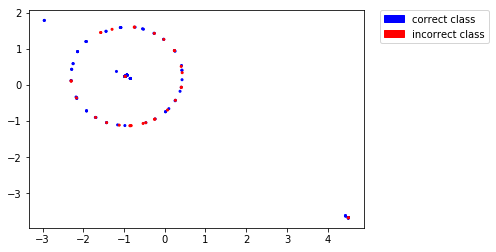

In [78]:
col = ["b"] * num_correct + ["r"] * num_wrong
plt.scatter(vecs_embedded[:, 0], vecs_embedded[:, 1], s=4, c=col)

plt.legend(handles=[mpatches.Patch(color="b", label="correct class"), mpatches.Patch(color="r", label="incorrect class")], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


plt.show()

In [73]:
full_vecs = np.concatenate((ans_correct, ans_wrong), axis = 0)
for i in range(vecs_embedded.shape[0]):
    print(vecs_embedded[i], full_vecs[i])

[ 0.91164553 -0.7412076 ] [0. 0. 0. 0.]
[ 0.91164553 -0.7412078 ] [0. 0. 0. 0.]
[ 0.9107642  -0.74367446] [0. 0. 0. 0.]
[ 2.7426867 -3.1355548] [1. 0. 0. 0.]
[ 0.90751636 -0.73893934] [0. 0. 0. 0.]
[ 0.908126 -0.738546] [0. 0. 0. 0.]
[ 0.90751624 -0.73893934] [0. 0. 0. 0.]
[ 0.9081268  -0.73854595] [0. 0. 0. 0.]
[ 0.9078164  -0.73863465] [0. 0. 0. 0.]
[ 0.9075166  -0.73893946] [0. 0. 0. 0.]
[ 0.90812606 -0.7385457 ] [0. 0. 0. 0.]
[ 0.90809697 -0.73894113] [0. 0. 0. 0.]
[-4.387808  4.561576] [0. 1. 1. 1.]
[ 0.9075161  -0.73893964] [0. 0. 0. 0.]
[-4.3808103  4.5616612] [0. 1. 1. 1.]
[ 0.907516   -0.73893946] [0. 0. 0. 0.]
[ 0.90809745 -0.7389417 ] [0. 0. 0. 0.]
[ 0.9072458 -0.7385404] [0. 0. 0. 0.]
[ 0.9081268  -0.73854595] [0. 0. 0. 0.]
[ 0.90751654 -0.7389392 ] [0. 0. 0. 0.]
[ 0.9075164 -0.7389396] [0. 0. 0. 0.]
[ 0.90724593 -0.73854035] [0. 0. 0. 0.]
[ 0.9075162 -0.7389394] [0. 0. 0. 0.]
[ 0.9075161 -0.7389394] [0. 0. 0. 0.]
[ 0.90751636 -0.73893946] [0. 0. 0. 0.]
[ 0.9078139  -0.7389

[-0.50450134  0.8077453 ] [0. 0. 0. 0.]
[0.3585163 0.958495 ] [0. 0. 0. 0.]
[-1.0983294 -0.9707438] [0. 0. 0. 0.]
[0.22365129 0.18509999] [0. 0. 0. 0.]
[1.6502488 1.0836221] [0. 0. 0. 0.]
[-1.1191133 -0.2451051] [0. 0. 0. 0.]
[-0.54810286 -0.21231197] [0. 0. 0. 0.]
[0.23668317 0.18017699] [0. 0. 0. 0.]
[0.21709388 0.1796015 ] [0. 0. 0. 0.]
[1.6502446 1.0836229] [0. 0. 0. 0.]
[-0.17831758 -0.3298655 ] [0. 0. 0. 0.]
[0.14382976 1.2404416 ] [0. 0. 0. 0.]
[-0.17985645 -0.33157444] [0. 0. 0. 0.]
[0.23800321 0.17783399] [0. 0. 0. 0.]
[0.50726104 0.327792  ] [0. 0. 0. 0.]
[1.6502485 1.0836391] [0. 0. 0. 0.]
[-0.18007591 -0.33149284] [0. 0. 0. 0.]
[-1.0983322  -0.97074383] [0. 0. 0. 0.]
[-0.08203503 -0.22133917] [0. 0. 0. 0.]
[-1.1173434  -0.19802018] [0. 0. 0. 0.]
[0.87260103 1.333991  ] [0. 0. 0. 0.]
[0.06061897 0.00453194] [0. 0. 0. 0.]
[0.82401234 0.3741623 ] [0. 0. 0. 0.]
[0.45438382 0.2966612 ] [0. 0. 0. 0.]
[-0.5567399   0.49120298] [0. 0. 0. 0.]
[0.72105134 1.3257912 ] [0. 0. 0. 0.]
[1